### Imports

In [1]:
from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

import numpy as np

from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner
from basix.ufl import element

import tt
from tt import cross

from als_cross import als_cross

### Problem definition

In [2]:
c_dim = 10

def dirichlet_boundary(x):
  return np.full(x.shape[1], True)

class coeff:
  def __init__(self, d, nu, k0=1, sigma2=1):
    self.d = d
    self.nu = nu
    self.k0 = k0
    self.sigma2 = sigma2

    self.y = np.zeros(d)

    D = np.arange(self.d, dtype=np.double) - k0 + 1
    D[:k0] = 1
    D = np.power(D, -nu-1)

    self.sqrteta = np.sqrt(sigma2 * D / np.sum(D))

    tau = np.floor(-0.5 + np.sqrt(2 * np.arange(self.d) + 2.25))

    self.pi2rho1 = 1 + np.arange(self.d) - 0.5 * tau * (tau + 1)
    self.pi2rho2 = tau - self.pi2rho1
    self.pi2rho1 *= 2 * np.pi
    self.pi2rho2 *= 2 * np.pi

    print(self.sqrteta)
    
  def __call__(self, x):
    res = np.sum(self.y * self.sqrteta * np.cos(np.outer(x[0], self.pi2rho1)) * np.cos(np.outer(x[1], self.pi2rho2)), axis=1)

    return np.exp(res)
  
diffusion_c = coeff(d=c_dim, nu = 3)
  
# def diffusion_c(x, eps=1e-1):
#   return np.full(x.shape[1], eps)

def convection_b(x, dir=(-0,-0)):
  return np.vstack([np.full(x.shape[1], dir[0]), np.full(x.shape[1], dir[1])])

[0.69305269 0.69305269 0.17326317 0.07700585 0.04331579 0.02772211
 0.01925146 0.01414393 0.01082895 0.00855621]


### FEM setup

In [3]:
msh = mesh.create_unit_square(comm=MPI.COMM_WORLD,
                              nx=64, ny=64,
                              cell_type=mesh.CellType.triangle)

V = fem.functionspace(msh, ("Lagrange", 1))

# dirichlet = np.zeros(1, dtype=PETSc.ScalarType)  # type: ignore
facets = mesh.locate_entities_boundary(msh, 1, dirichlet_boundary)
bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(V, 1, facets), V)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

Vb = fem.functionspace(msh, element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,)))
b = fem.Function(Vb)
dir = np.random.uniform(-5,5,2)
b.interpolate(lambda x: convection_b(x, dir))

c = fem.Function(V)
diffusion_c.y = np.random.uniform(-3,3,10)
c.interpolate(diffusion_c)

a0 = c * inner(grad(u), grad(v)) * dx
a1 = inner(b, grad(u)) * v * dx
a = a0 + a1
L = v * dx # RHS is constant 1

In [4]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

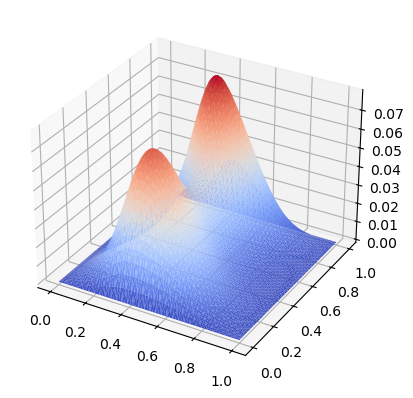

In [5]:
cells, cell_types, x = plot.vtk_mesh(V)
N = x.shape[0]

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.plot_trisurf(x.T[0], x.T[1], uh.x.array, cmap='coolwarm')

In [6]:
class convection_diffusion_PDE_fun:
  def __init__(self):
    self.msh = mesh.create_unit_square(comm=MPI.COMM_WORLD,
                              nx=64, ny=64,
                              cell_type=mesh.CellType.triangle)

    self.V = fem.functionspace(self.msh, ("Lagrange", 1))

    # dirichlet = np.zeros(msh.geometry.dim, dtype=PETSc.ScalarType)  # type: ignore
    facets = mesh.locate_entities_boundary(self.msh, 1, dirichlet_boundary)
    dirichlet_bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(self.V, 1, facets), self.V)
    self.bcs = [dirichlet_bc]

    u = ufl.TrialFunction(self.V)
    v = ufl.TestFunction(self.V)

    self.Vb = fem.functionspace(self.msh, element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,)))
    self.b = fem.Function(self.Vb)

    self.c = fem.Function(self.V)

    self.a0 = fem.form(self.c * inner(grad(u), grad(v)) * dx)
    self.a1 = fem.form(inner(self.b, grad(u)) * v * dx)
    self.a = self.c * inner(grad(u), grad(v)) * dx + inner(self.b, grad(u)) * v * dx
    self.L = fem.form(v * dx) # RHS is constant 1

    # precompute constant matrix part
    self.c.interpolate(lambda x : np.zeros(x.shape[1]))
    self.b.interpolate(lambda x: np.zeros((2, x.shape[1])))

    A0 = fem.petsc.assemble_matrix(self.a0, bcs=self.bcs)
    A0.assemble()
    # A.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    ai, aj, av = A0.getValuesCSR()
    self.A0_const = csr_matrix((av, aj, ai))
    A1 = fem.petsc.assemble_matrix(self.a1, bcs=self.bcs)
    A1.assemble()
    # A.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    ai, aj, av = A1.getValuesCSR()
    self.A1_const = csr_matrix((av, aj, ai))


    b0 = fem.petsc.assemble_vector(self.L)
    fem.petsc.apply_lifting(b0, [fem.form(self.a)], bcs=[self.bcs])
    b0.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b0, self.bcs)
    self.b_const = b0.getArray()

  def matrix(self,coeff):
    if len(coeff) != 3:
      raise Exception(f"Wrong number of matrix components ({len(coeff)} != 3).")
    
    [num_coeff, nx, I] = np.shape(coeff[0])
    c_dofs = coeff[0][0,:,:]
    A0 = []
    for i in range(I):
      for k in range(self.c.x.array.shape[0]):
        self.c.x.array[k] = c_dofs[k,i]
        
      A = fem.petsc.assemble_matrix(self.a0, bcs=self.bcs)
      A.assemble()
      ai, aj, av = A.getValuesCSR()
      A0.append(csr_matrix((av, aj, ai)) - self.A0_const)

    [num_coeff, nx, I] = np.shape(coeff[1])
    b_dofs = coeff[1][0,:,:]
    A1 = []
    for i in range(I):
      for k in range(self.b.x.array.shape[0]):
        self.b.x.array[k] = b_dofs[k,i]
        
      A = fem.petsc.assemble_matrix(self.a1, bcs=self.bcs)
      A.assemble()
      ai, aj, av = A.getValuesCSR()
      A1.append(csr_matrix((av, aj, ai)) - self.A1_const)
    
    [num_coeff, nx, I] = np.shape(coeff[2])
    A2 = []
    for i in range(I):
      A2.append(self.A0_const + self.A1_const)
    
    return [A0, A1, A2]
  
  def rhs(self, coeff):
    if len(coeff) != 1:
      raise Exception(f"Wrong number of rhs components ({len(coeff)} != 1).")
       
    [num_coeff, nx, I] = np.shape(coeff[0])
    b0 = []
    for i in range(I):
      b0.append(self.b_const.reshape(-1,1))
    
    return [b0]
  
  def solve(self, coeff):

    [num_coeff, nx, I] = np.shape(coeff[0][0])
    
    U = []

    for i in range(I):
      for k in range(self.c.x.array.shape[0]):
        self.c.x.array[k] = coeff[0][0][0,k,i]
      for k in range(self.b.x.array.shape[0]):
        self.b.x.array[k] = coeff[0][1][0,k,i]

      U.append(self.solve_internal().reshape((-1,1)))
    
    return U

  def solve_internal(self):
    problem = LinearProblem(self.a, self.L, bcs=self.bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()

    return np.array(uh.x.array)

### TT decomposition of coefficients

In [9]:
cells, cell_types, coords = plot.vtk_mesh(V)

Ny_c = np.array(c_dim * [10])
Ny_b = np.array(2 * [10])
Nx = coords.shape[0]

ypoints_c = (6 * (0.5 * np.polynomial.legendre.leggauss(Ny_c[0])[0] + 0.5) - 3)
def c_func(x):
  res = np.empty(x.shape[0])
  for i, xi in enumerate(x):    
    diffusion_c.y = ypoints_c[xi[3:]]
    res[i] = diffusion_c(coords[xi[0]].reshape(-1,1))[0]
  
  return res

# random init tensor
TT_c = tt.rand(np.array([Nx] + Ny_b.tolist() + Ny_c.tolist()),r=10)
# compute TT approx using TT-cross
TT_c = tt.cross.rect_cross.cross(c_func, TT_c, nswp=10, eps = 1e-5, kickrank=5)
TT_c = TT_c.round(1e-12)

print("c TT ranks: ", TT_c.r)

ypoints_b = (6 * (0.5 * np.polynomial.legendre.leggauss(Ny_b[0])[0] + 0.5) - 3)
def b_func(x):
  res = np.empty(x.shape[0])
  for i, xi in enumerate(x):
    if xi[0] % 2 == 0:
      res[i] = ypoints_b[xi[1]]
    else:
      res[i] = ypoints_b[xi[2]]
  
  return res

# random init tensor
TT_b = tt.rand(np.array([2*Nx] + Ny_b.tolist() + Ny_c.tolist()),r=10)
# compute TT approx using TT-cross
TT_b = tt.cross.rect_cross.cross(b_func, TT_b, nswp=10, eps = 1e-5, kickrank=5)
TT_b = TT_b.round(1e-12)

print("b TT ranks: ", TT_b.r)

# helper tensor that is constant 1
cores = [np.ones((1,1,1))]
for i in range(len(Ny_b)):
  cores += [np.ones((1,Ny_b[i],1))]
for i in range(len(Ny_c)):
  cores += [np.ones((1,Ny_c[i],1))]

TT_const = tt.vector.from_list(cores)

swp: 0/9 er_rel = 2.7e+05 er_abs = 8.2e+13 erank = 20.1 fun_eval: 176100
swp: 1/9 er_rel = 1.6e-01 er_abs = 5.3e+07 erank = 31.1 fun_eval: 533780
swp: 2/9 er_rel = 7.6e-02 er_abs = 2.6e+07 erank = 42.8 fun_eval: 1144550
swp: 3/9 er_rel = 4.8e-01 er_abs = 1.9e+08 erank = 55.3 fun_eval: 2085520
swp: 4/9 er_rel = 5.3e-02 er_abs = 2.1e+07 erank = 67.9 fun_eval: 3439010
swp: 5/9 er_rel = 1.1e-02 er_abs = 4.5e+06 erank = 80.4 fun_eval: 5273210
swp: 6/9 er_rel = 8.9e-04 er_abs = 3.5e+05 erank = 92.7 fun_eval: 7650360
swp: 7/9 er_rel = 8.7e-05 er_abs = 3.4e+04 erank = 105.0 fun_eval: 10630330
swp: 8/9 er_rel = 1.4e-05 er_abs = 5.4e+03 erank = 117.1 fun_eval: 14279915
swp: 9/9 er_rel = 5.6e-06 er_abs = 2.2e+03 erank = 129.5 fun_eval: 18665195
c TT ranks:  [  1 129 131 129 129 128 141 132 148 148 145 100  10   1]
swp: 0/9 er_rel = 4.6e+05 er_abs = 8.8e+13 erank = 19.8 fun_eval: 301800
swp: 1/9 er_rel = 6.1e-15 er_abs = 1.2e-06 erank = 29.6 fun_eval: 854600
b TT ranks:  [1 2 2 1 1 1 1 1 1 1 1 1 1

### Run ALS cross

In [25]:
PDE_fun = convection_diffusion_PDE_fun()

test = als_cross(
  [TT_c, TT_b, TT_const],
  [TT_const],
  PDE_fun,
  1e-8,
  # random_init=30,
  kickrank=10
  )

test.iterate(3)
print(test.get_stats())

u = test.get_tensor()

print('Ranks', u.r)

= swp=1 core 0, max_dx=1.000e+00, max_rank = 148
= swp=1 core 1>, dx=1.000e+00, rank = [138, 140]
= swp=1 core 2>, dx=1.000e+00, rank = [140, 138]
= swp=1 core 3>, dx=1.000e+00, rank = [138, 138]
= swp=1 core 4>, dx=1.000e+00, rank = [138, 137]
= swp=1 core 5>, dx=1.000e+00, rank = [137, 151]
= swp=1 core 6>, dx=1.000e+00, rank = [151, 141]
= swp=1 core 7>, dx=1.000e+00, rank = [141, 137]
= swp=1 core 8>, dx=1.000e+00, rank = [137, 73]
= swp=1 core 9>, dx=1.000e+00, rank = [73, 41]
= swp=1 core 10>, dx=1.000e+00, rank = [41, 19]
= swp=1 core 11>, dx=1.000e+00, rank = [19, 5]
= swp=1 fwd finish, max_dx=1.000e+00, max_rank = 151
= swp=2 core <12, dx=0.000e+00, rank = [5, 1]
= swp=2 core <11, dx=3.643e-10, rank = [19, 5]
= swp=2 core <10, dx=1.724e-09, rank = [40, 19]
= swp=2 core <9, dx=1.242e-09, rank = [72, 40]
= swp=2 core <8, dx=2.078e-09, rank = [131, 72]
= swp=2 core <7, dx=2.242e-09, rank = [150, 131]
= swp=2 core <6, dx=7.285e-08, rank = [161, 150]
= swp=2 core <5, dx=1.011e-06, 

In [26]:
from scipy.interpolate import BarycentricInterpolator

class eval_collocation:
  def __init__(self, tt_tensor):
    self.cores = tt.vector.to_list(tt_tensor)
    self.r = tt_tensor.r
    self.n = tt_tensor.n[1:]
    
    self.xpoints = []
    for n_i in self.n:
      self.xpoints.append(6 * (0.5 * np.polynomial.legendre.leggauss(n_i)[0] + 0.5) - 3)

    self.polys = []
    for i in range(len(self.n)):
      polys_i = []
      z = np.zeros(self.n[i])
      z[0] = 1
      for k in range(self.n[i]):
        polys_i.append(BarycentricInterpolator(self.xpoints[i], z.copy()))
        # polys_i.append(P.fit(self.xpoints[i], z, self.n[i]-1))
        if k < self.n[i] - 1:
          z[k+1] = 1
          z[k] = 0
      
      self.polys.append(polys_i)

  def __call__(self, y):
    res = np.ones((1,1))
    for i in reversed(range(len(self.n))):
      weight = np.empty((1,self.n[i],1))
      for k in range(self.n[i]):
        weight[0,k,0] = self.polys[i][k](y[i])

      res = np.sum(self.cores[i+1] * weight, axis = 1).reshape(-1, self.r[i+2]) @ res.reshape(self.r[i+2], -1)

    return (self.cores[0].reshape(-1, self.r[1]) @ res.reshape(self.r[1], -1)).flatten()

Text(0.5, 0.92, 'Error')

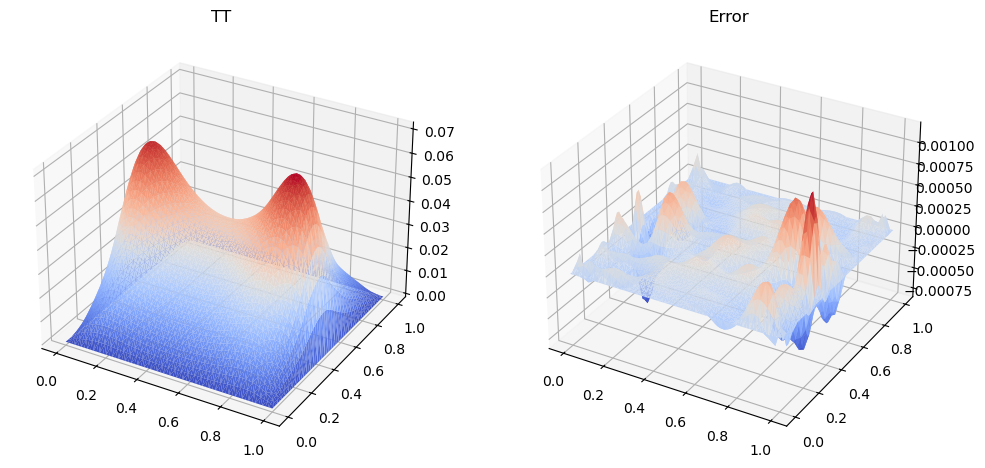

In [33]:
cells, cell_types, x = plot.vtk_mesh(V)
N = x.shape[0]

y = np.random.uniform(-3,3,12)

# TT approx with collocation
u_coll = eval_collocation(u)(y)

# get FE solution
diffusion_c.y = y[2:]
PDE_fun.c.interpolate(diffusion_c)
PDE_fun.b.interpolate(lambda x: convection_b(x, y[:2]))
u_ref = PDE_fun.solve_internal()

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12,6))

axs[0].plot_trisurf(x.T[0], x.T[1], u_coll, cmap='coolwarm')
axs[0].set_title('TT')

axs[1].plot_trisurf(x.T[0], x.T[1], u_coll-u_ref, cmap='coolwarm')
axs[1].set_title('Error')